### The premise of this notebook is to archetype a script for extracting motion energy features from a movie using Pymoten.

Information:
From [Finn's paper](https://www.sciencedirect.com/science/article/pii/S1053811921002408)  
- MOVIE runs 1–4 were 921, 918, 915, and 901 TRs, respectively.  
---------- frames / fps / total time / width / height  
movie 1  22104 24.0 921.0 1024 720  
movie 2  22032 24.0 918.0 1024 720  
movie 3  21960 24.0 915.0 1024 720  
movie 4  21624 24.0 901.0 1024 720  


downsampled movies by 8, (128.0, 90.0)

The steps can be as follows:  
make conda environment 
1. Movies to png to luminance
2. Create pyramid
3. Push luminance through pyramid
4. Save features
5. Clean features


import stuff

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import json
import subprocess
from skimage import io
from skimage.transform import resize
from skimage import img_as_ubyte
import imageio
import numpy as np
import skvideo 
skvideo.setFFmpegPath("/srv/conda/envs/lowlevel/bin")
import skvideo.io 
from moviepy.editor import VideoFileClip
from skimage.transform import resize
from tqdm import tqdm
import moten
import PIL.Image as pil_image


In [3]:
def rgb_to_gray_luminosity(rgb_image):
    red_weight = 0.2989
    green_weight = 0.5870
    blue_weight = 0.1140
    
    gray_image = np.dot(rgb_image[..., :3], [red_weight, green_weight, blue_weight])
    return gray_image.astype(np.uint8)

In [4]:
def load_resize_image(img, hdim, vdim):
    # img = io.imread(image)
    img = resize(img, (hdim, vdim))
    img = img_as_ubyte(img)
    return img

In [5]:
def movie_to_gray_array(json_filepath):
    #open feature json file
    with open(json_filepath) as f:
        data = json.load(f)

    ## isolate all info for each stimuli
    for stimuli, stimuli_data in data.items():
        hdim = stimuli_data['hdim']
        vdim = stimuli_data['vdim']
        downloadpath = stimuli_data['downloadpath']
        movies = stimuli_data['movies']
        savepath = stimuli_data['savepath']
        for movie in movies:
            moviepath = os.path.join(downloadpath, movie)

            # Define the output directory where the .png images will be saved.
            movienoextension = movie[:len(movie)-4]
            output_directory = f'{savepath} + {movienoextension}/'
            if not os.path.exists(output_directory):
                os.makedirs(output_directory)
                
            # Open the video file using VideoFileClip
            video = VideoFileClip(moviepath)
            width = int(video.size[0]/8)
            height = int(video.size[1]/8)
            total_frames = (int(video.fps * video.duration))
            gray_image_data = np.empty((height, width, total_frames), dtype=np.uint8)
            pbar = tqdm(total=total_frames, desc=movie)

            counter = 0
            for idx, frame in enumerate(video.iter_frames(fps=video.fps, dtype='uint8')):
                #downsample
                #print(frame.shape, hdim, vdim)
                img = load_resize_image(frame, hdim, vdim)
                #print(img.shape)
                gray_image_data[:, :, idx] = rgb_to_gray_luminosity(img)
                pbar.update(1)
                counter += 1
                if counter % 1000 == 0:
                     break

            pbar.close()
            np.savez(savepath + movienoextension + '_gray.npz', movie=gray_image_data)
            return gray_image_data
        
            # Close the video file
            video.reader.close()


In [ ]:
#code to extract hdim, vdim, fps, etc

In [6]:
movie_to_gray_array('/home/jovyan/workingdirectory/feature.json')

7T_MOVIE1_CC1_v2.mp4:   0%|          | 16/22104 [00:03<1:25:55,  4.28it/s]

KeyboardInterrupt: 

let's just save out 1000 frames to build the pyramid for

In [18]:
def push_thru_pyramid(json_filepath):
    #open feature json file
    with open(json_filepath) as f:
        data = json.load(f)

    # load in json data
    for stimuli, stimuli_data in data.items():
            hdim = stimuli_data['hdim']
            vdim = stimuli_data['vdim']
            fps = stimuli_data['fps']
            tf = stimuli_data['tf']
            sf = stimuli_data['sf']
            ori = stimuli_data['ori']
            downloadpath = stimuli_data['downloadpath']
            movies = stimuli_data['movies']
            savepath = stimuli_data['savepath']
            
            pyramid = moten.pyramids.MotionEnergyPyramid(stimulus_vhsize=(hdim, vdim), 
                                       stimulus_fps=fps, 
                                       temporal_frequencies=tf, 
                                       spatial_frequencies=sf, 
                                       spatial_directions=ori)
            
            for movie in movies:
                movienoextension = movie[:len(movie)-4]
                data = np.load(savepath + movienoextension + ".mp4_gray.npz", allow_pickle=True)['movie']
                #data expected to be nimages, vdim, hdim
                reorganized_array = np.transpose(data, (2, 0, 1))
                features = pyramid.project_stimulus(reorganized_array)
                np.savez(savepath + movienoextension + "_features.npz", features=features)
                
                
    
    
    

In [19]:
push_thru_pyramid('/home/jovyan/workingdirectory/feature.json')


project_stimulus: 100%|██████████| 8/8 [00:05<00:00,  1.57it/s]

project_stimulus: 100%|██████████| 8/8 [00:05<00:00,  1.59it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/workingdirectory/7T_MOVIE3_CC2_v2.mp4_gray.npz'

In [21]:
features = np.load("/home/jovyan/workingdirectory/7T_MOVIE1_CC1_v2_features.npz")['features']

In [22]:
features.shape

(22104, 8)

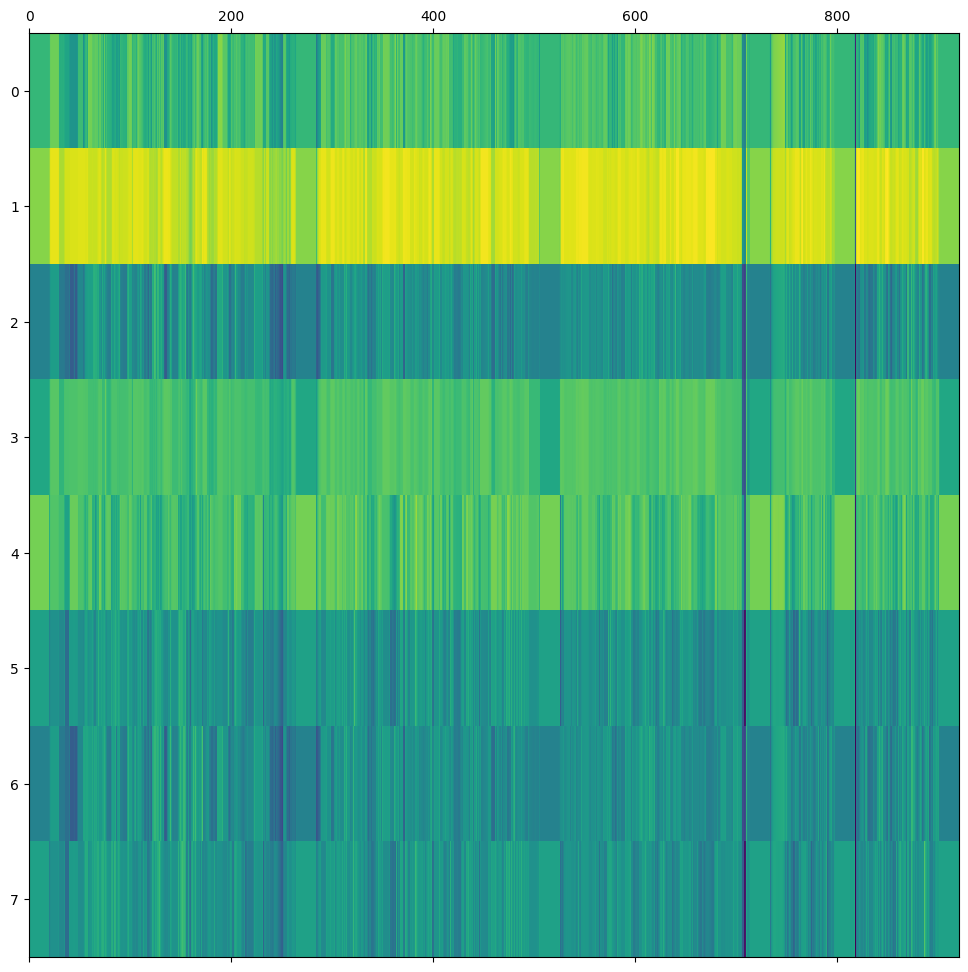

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 12))
ax.matshow(features, aspect='auto')
plt.show()

In [ ]:
def decimate_array(fps, sr):
    

In [ ]:
# import numpy as np

# # Sample (8100, 9216) array
# total_frames = x
# sr = 1
# fps = 24
# num_bins = total_frames / fps*sr

# def hanning_filter_3D(frames, downsample_factor=fps):
#     # Number of frames and frame size.
#     num_frames, height, width = frames.shape

#     # Create a Hanning window as the low-pass filter.
#     hanning_window = np.hanning(downsample_factor)

#     # Initialize an array to store the filtered frames.
#     filtered_frames = np.zeros((num_frames // downsample_factor, height, width))

#     # Apply Hanning filter to each group of 'downsample_factor' frames.
#     for i in range(0, num_frames, downsample_factor):
#         group_of_frames = frames[i:i+downsample_factor]
#         filtered_group = convolve(group_of_frames, hanning_window[:, None, None], mode='same')
#         filtered_frames[i // downsample_factor] = np.mean(filtered_group, axis=0)

#     return filtered_frames

In [1]:
pwd

'/home/jovyan/visual-feature-decoding/extract_features/motionenergy/archive'

In [2]:
cd ..

/home/jovyan/visual-feature-decoding/extract_features/motionenergy


In [3]:
import utils
import numpy as np

In [4]:
json_filepath = '/home/jovyan/visual-feature-decoding/extract_features/feature.json'

In [5]:
utils.push_thru_pyramid(json_filepath)

saved pyramid!
saved filters!
down_sampled features for 7T_MOVIE1_CC1_v2.mp4 already done!
down_sampled features for 7T_MOVIE2_HO1_v2.mp4 already done!


project_stimulus: 100%|██████████| 1580/1580 [05:38<00:00,  4.67it/s]


(21960, 1580)


FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/workingdirectory/7T_MOVIE4_HO2_v2_gray.npz'

In [ ]:
features = np.load("/home/jovyan/workingdirectory/7T_MOVIE1_CC1_v2_downsampledfeatures.npz", allow_pickle=True)['features']

In [ ]:
features.shape

In [7]:
import numpy as np
from scipy import signal
from tqdm import tqdm

import numpy as np
from scipy import signal

def downsample_matrix(matrix, factor):
    original_rows, original_cols = matrix.shape
    new_cols = original_cols // factor

    downsampled_matrix = np.empty((original_rows, new_cols))

    for i in range(original_rows):
        for j in range(new_cols):
            start_idx = j * factor
            end_idx = start_idx + factor
            segment = matrix[i, start_idx:end_idx]
            downsampled_matrix[i, j] = np.sum(segment * signal.windows.hann(factor)) / factor

    return downsampled_matrix

# Example usage
downsample_factor = 24
downsampled_matrix = downsample_matrix(features, downsample_factor)


In [8]:
downsampled_matrix.shape

(8, 921)